In [171]:
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
from scipy import ndimage

In [172]:
def save_picture(filename, source):
  image = Image.fromarray(np.uint8(source))
  image.save('./'+filename, dpi=(200, 200))

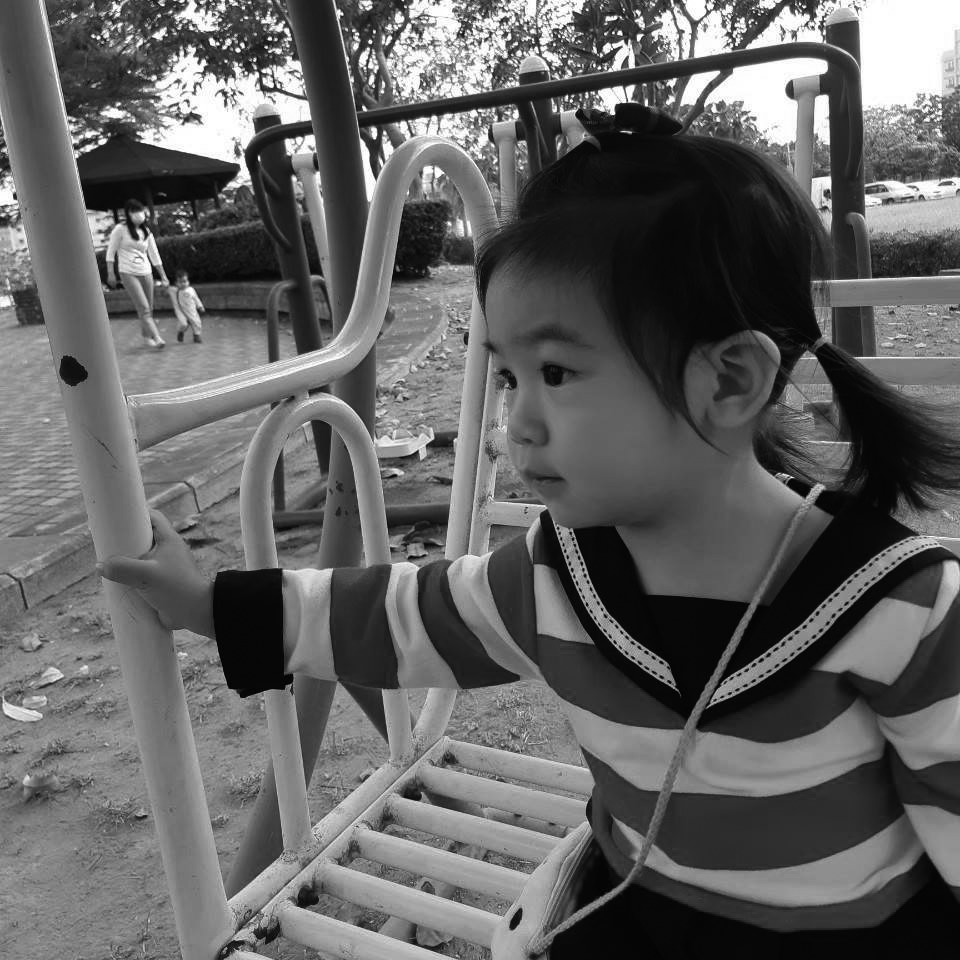

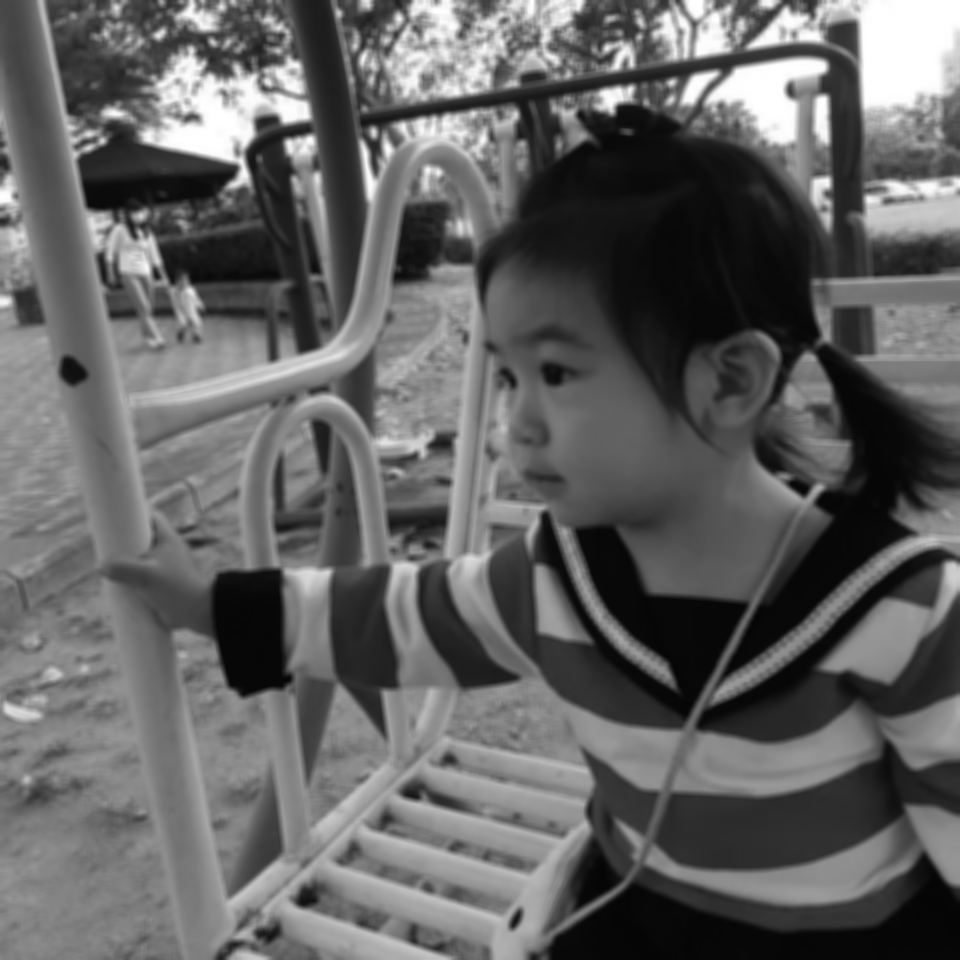

In [173]:
#readfile and perform gaussian blur
img = cv.imread('Kid at playground.tif', cv.IMREAD_GRAYSCALE)
blur = cv.GaussianBlur(img, (7, 7), min(img.shape[0], img.shape[1] * 0.005))
cv2_imshow(img)
cv2_imshow(blur)

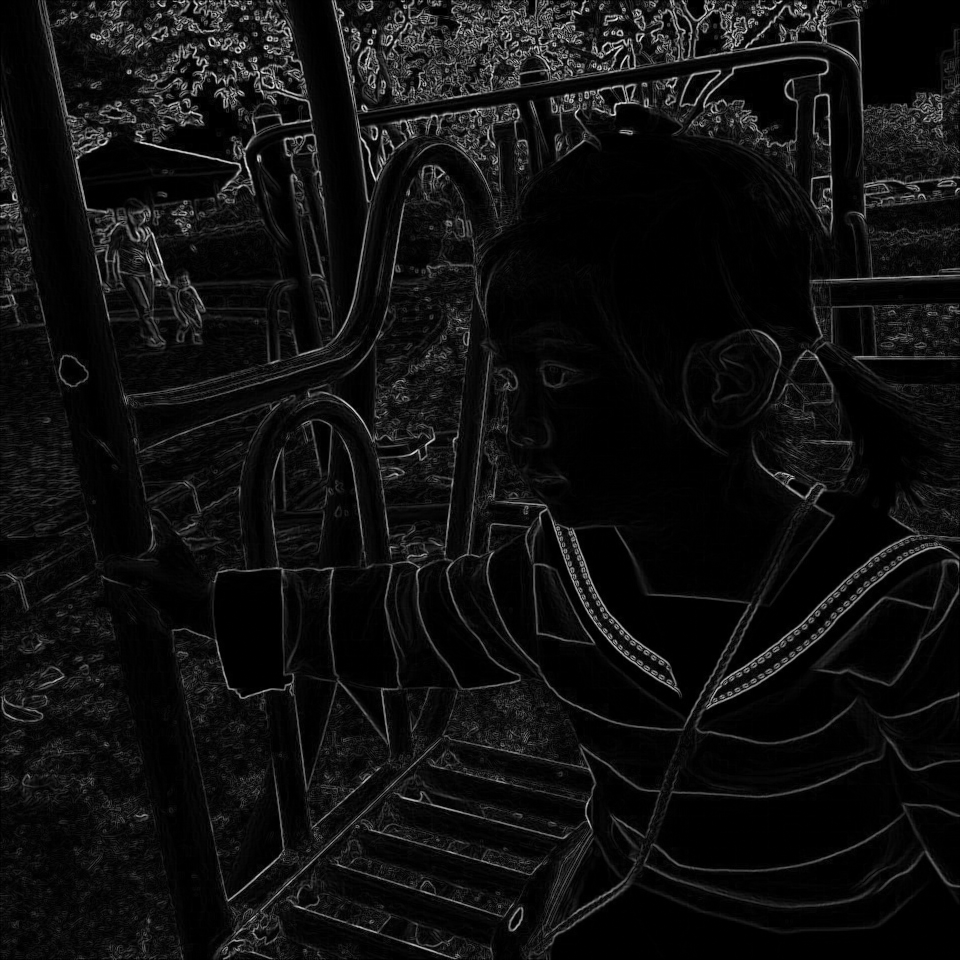

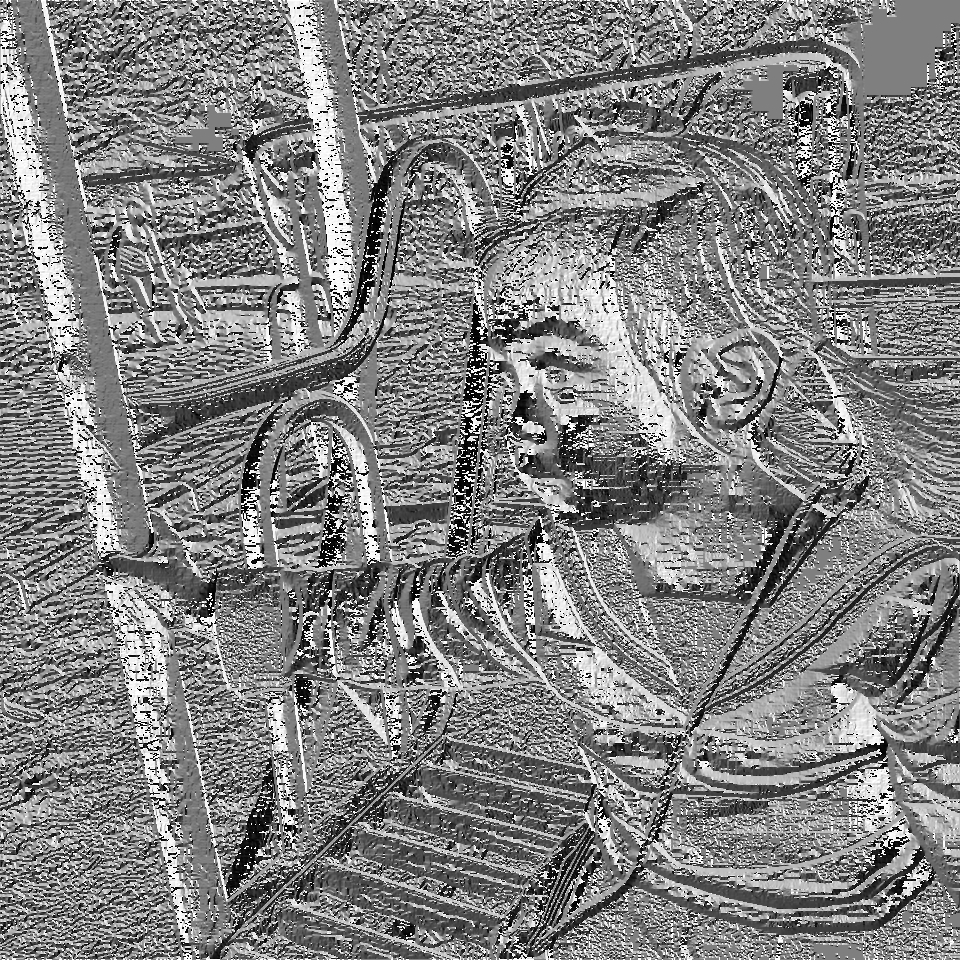

In [174]:
#Sobel gradient
gx = cv.Sobel(np.float32(img), cv.CV_32F, 1, 0, 3)
gy = cv.Sobel(np.float32(img), cv.CV_32F, 0, 1, 3)

G = cv.addWeighted(np.abs(gx), 0.5, np.abs(gy),0.5,0)
G = G / G.max() * 255

theta = np.rad2deg(np.arctan2(gy, gx))

cv2_imshow(G)
cv2_imshow((theta + 180) * 255 / 360)

save_picture('Gradient_Magnitude.png', G)
save_picture('Gradient_Angle.png', (theta + 180) * 255 / 360)

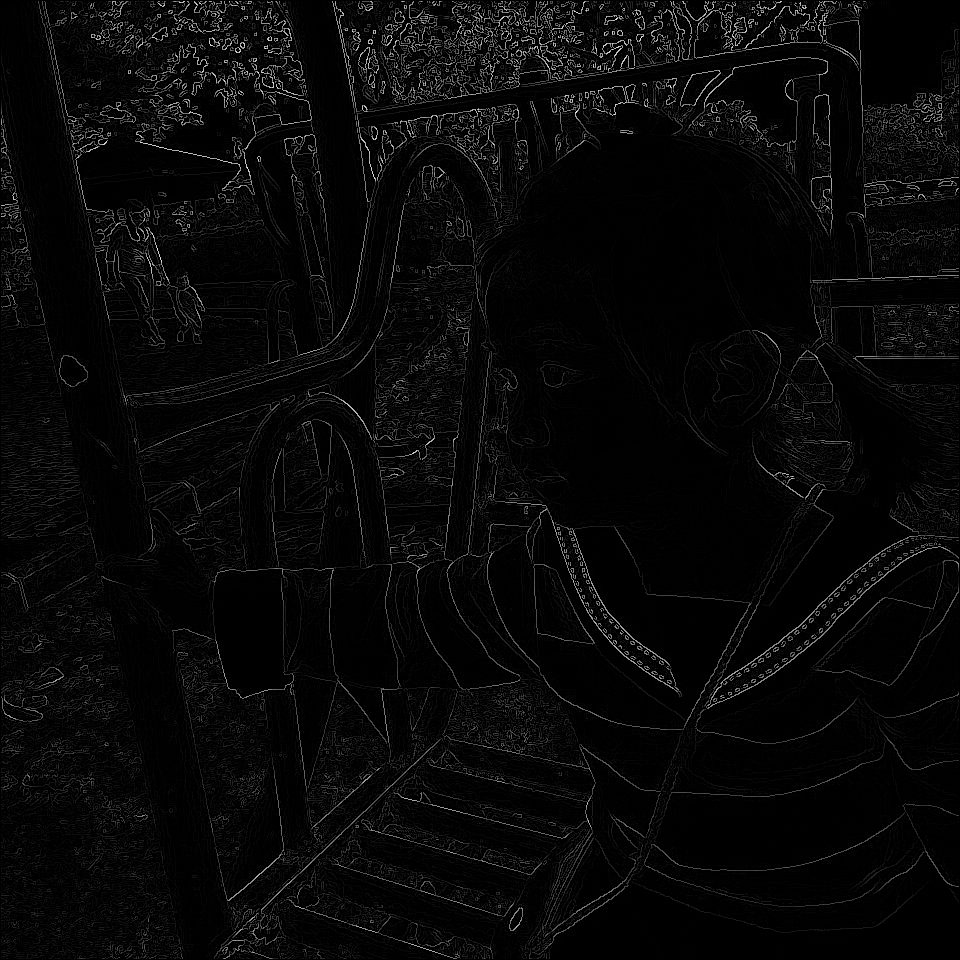

In [175]:
#perform nonmaxima suppression

size = G.shape
gN = np.zeros(size)
theta[theta < 0] += 180

for i in range(1, size[0] - 1):
    for j in range(1, size[1] - 1):

        # d1 : horizontal edge
        if (0 <= theta[i, j] < 22.5) or (157.5 <= theta[i, j] <= 180):
            temp = max(G[i, j - 1], G[i, j + 1])
        
        # d2 : -45 deg edge
        elif (22.5 <= theta[i, j] < 67.5):
            temp = max(G[i - 1, j - 1], G[i + 1, j + 1])

        # d3 :  vertical edge
        elif (67.5 <= theta[i, j] < 112.5):
            temp = max(G[i - 1, j], G[i + 1, j])

        # d4 : +45 deg edge
        else:
            temp = max(G[i + 1, j - 1], G[i - 1, j + 1])
        
        if G[i, j] >= temp:
            gN[i, j] = G[i, j]

gN = np.multiply(gN, 255.0 / gN.max())
cv2_imshow(gN)
save_picture('Non-MaximaSuppressedImage.png', gN)

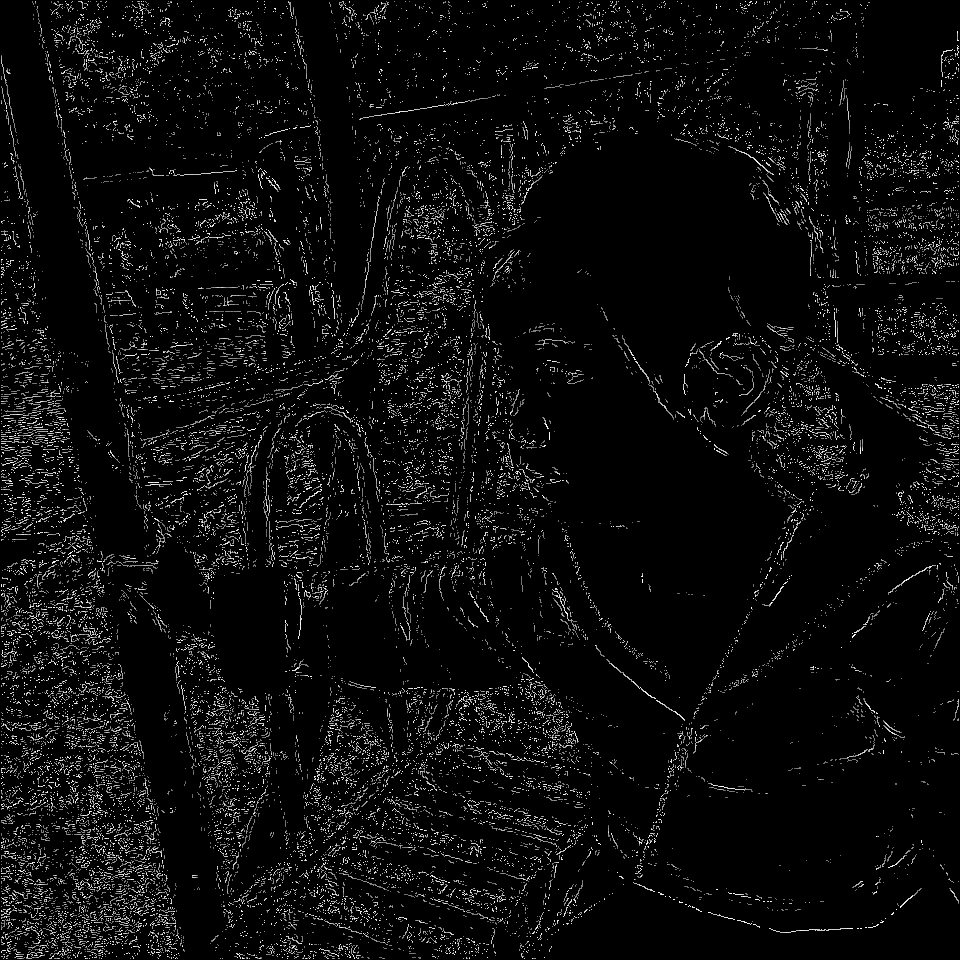

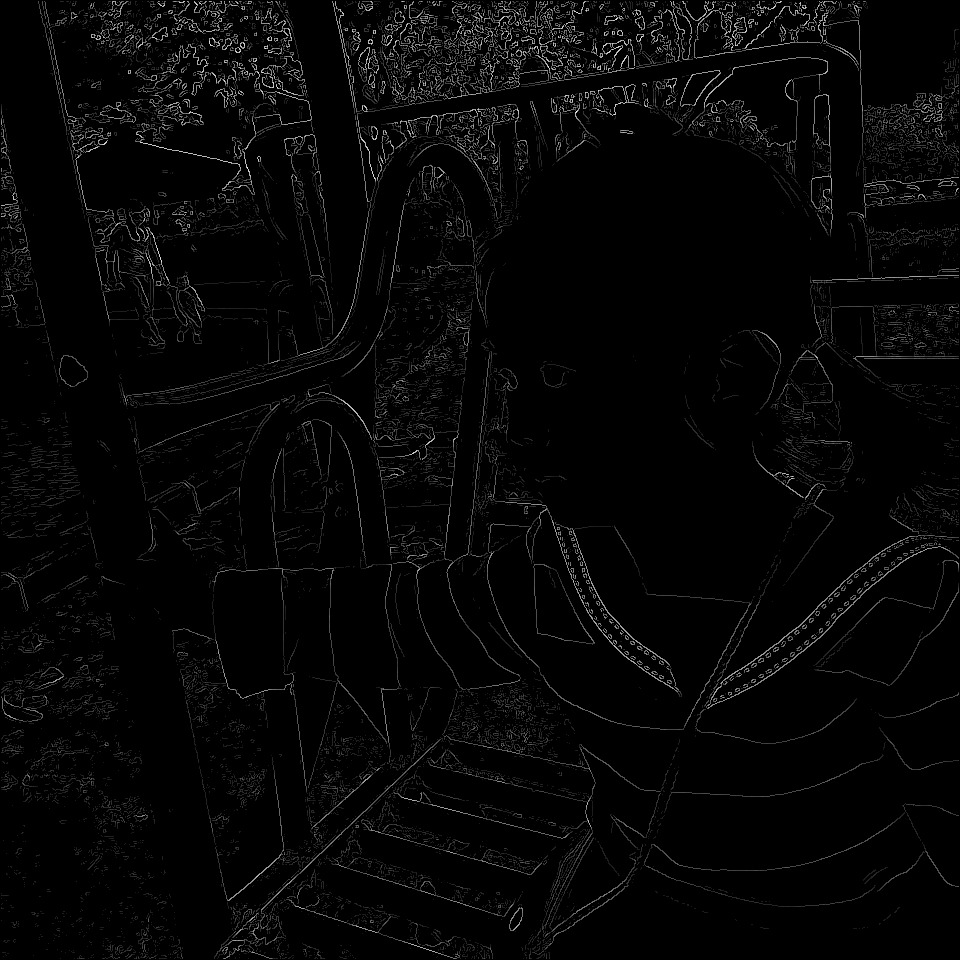

In [176]:
#get weak and strong
gN = gN / 255
size = gN.shape
gNL = np.zeros(size)
gNH = np.zeros(size)

TL = 0.04
TH = 0.1

for i in range(size[0]):
    for j in range(size[1]):
        if gN[i,j] >= TH:
            gNH[i,j] = gN[i,j]
        if TL <= gN[i,j] and gN[i,j] <= TH:
            gNL[i,j] = gN[i,j]

gNL = np.multiply(gNL, 255.0 / gNL.max())
gNH = np.multiply(gNH, 255.0 / gNH.max())

cv2_imshow(gNL)
cv2_imshow(gNH)
save_picture('gNL.png', gNL)
save_picture('gNH.png', gNH)

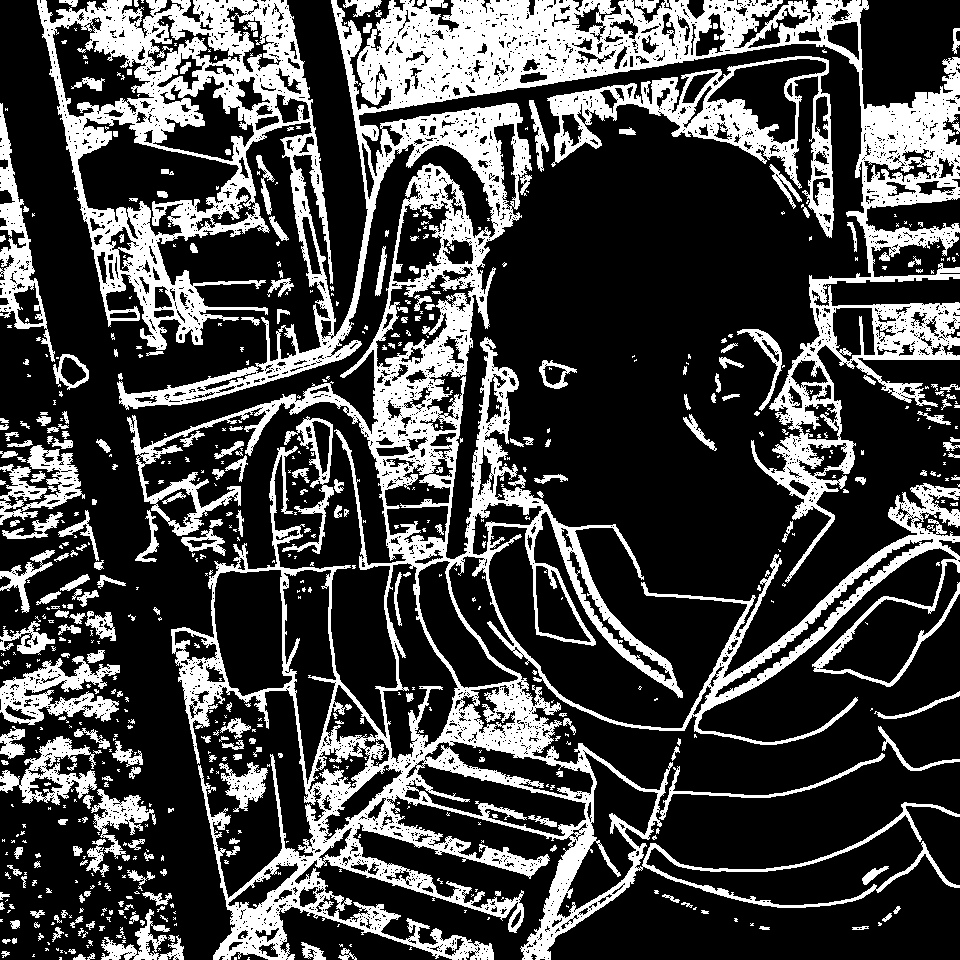

In [177]:
#perform hysterisis thresholding

size = gN.shape
e = np.zeros(size)

for i in range(1, size[0] - 1):
    for j in range(1, size[1] - 1):
        if gNH[i,j] != 0:
            e[i,j] = 1

            if gN[i-1, j-1] == gNL[i-1, j-1]:
                e[i-1,j-1] = 1
            if gN[i-1, j] == gNL[i-1, j]:
                e[i-1,j] = 1
            if gN[i-1, j+1] == gNL[i-1, j+1]:
                e[i-1,j+1] = 1
            if gN[i, j-1] == gNL[i, j-1]:
                e[i,j-1] = 1
            if gN[i, j+1] == gNL[i, j+1]:
                e[i,j+1] = 1
            if gN[i+1, j-1] == gNL[i+1, j-1]:
                e[i+1,j-1] = 1
            if gN[i+1, j] == gNL[i+1, j]:
                e[i+1,j] = 1
            if gN[i+1, j+1] == gNL[i+1, j+1]:
                e[i+1,j+1] = 1

e = np.multiply(e, 255.0 / e.max())
cv2_imshow(e)
save_picture('e.png', e)